In [2]:
from diatonic_tools.init import plt, sns

In [2]:
import numpy as np
from scipy.signal import find_peaks
from itertools import permutations
from dataclasses import dataclass
from multiprocessing import Pool

In [3]:
def plot_graph(x, y, title='', x_label='', y_label='', legend=''):
    plt.plot(x, y, label=legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if legend:
        plt.legend()
    plt.show()

In [200]:
SIGMA = 0.25
MIDI_RANGE = (20, 106)
MIDI_RESOLUTION = 100
MIDI_X = np.linspace(*MIDI_RANGE, MIDI_RESOLUTION * (MIDI_RANGE[1] - MIDI_RANGE[0] + 1))
N_OVERTONES = 13

def inverse_decay(x):
    return 1 / x

def exp_decay(x, b=0.07):
    return np.exp(-b * x)

def nop(x):
    return 1

DECAY_FN = inverse_decay

# TODO

decay function, number of overtones, sigma, and adding chord voices (addition or max or something else)
affect the result drastically.

also, until now, we have ignored the error. that is why some overtone series are detected as harmonious but sound discordant.
because in reality, the harmonious fundamental is 15 cents sharp or flat.

## Public functions

* `sweep`
* `top_n_peaks`
* `chord`
* `overtones`

Add all default values to the function definitions as parameters so that we do not have to change the constants at the top all the time.

In [201]:
def midi_to_hz(midi):
    return 440 * 2**((midi - 69) / 12)
def hz_to_midi(f):
    return 69 + 12 * np.log2(f / 440)

def normal_pdf(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))
def normal_at_midi(midi, std=SIGMA):
    return normal_pdf(MIDI_X, mu=midi, sigma=std)

def overtones(midi, n=N_OVERTONES, decay_fn=DECAY_FN):
    f0 = midi_to_hz(midi)
    result = np.zeros_like(MIDI_X)

    for i in range(1, n + 1):
        m = hz_to_midi(f0 * i)
        if m > MIDI_RANGE[1]:
            break
        result += normal_at_midi(m) * decay_fn(i)

    return result

def chord(notes, x_axis=MIDI_X):
    result = np.zeros_like(x_axis)
    for note in notes:
        result += overtones(note)
        # result = np.maximum(overtones(note), result)
    return result

In [202]:
eps = 1e-6
def compat(x, y):
    epsilon = np.ones_like(x) * eps
    result = np.minimum(x, y)
    result = np.maximum(result, epsilon)
    result = 1 -(1 / result)
    return np.sum(result)

def sweep(_chord, midi_range=MIDI_RANGE, resolution=0.25):
    start = midi_range[0]
    end = min(min(_chord), midi_range[1]) + resolution
    n_points = int((end - start) / resolution)
    x_axis = np.linspace(start, end, n_points)
    result = np.zeros_like(x_axis)
    chord_x = chord(_chord)
    for idx, midi in enumerate(x_axis):
        # result[idx] = overtones(midi) @ chord_x
        # result[idx] = np.sum(np.minimum(overtones(midi), chord_x))
        result[idx] = compat(overtones(midi), chord_x)
    return x_axis, result

def top_n_peaks(data, n=3):
    peaks, _ = find_peaks(data)
    sorted_peaks = sorted(peaks, key=lambda x: data[x], reverse=True)
    return sorted_peaks[:n]

def midi_to_note(midi_number):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_number // 12) - 1
    note_index = midi_number % 12
    return f"{notes[note_index]}{octave}"

In [203]:
my_chord = (60, 64, 67)
x_axis, swept = sweep(my_chord)

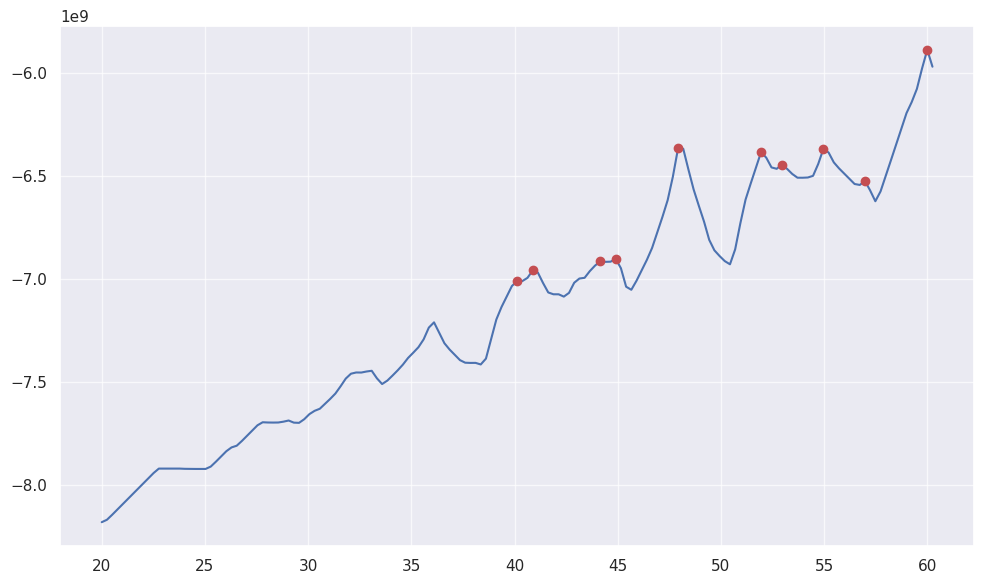

In [204]:
peaks = top_n_peaks(swept, 10)

plt.plot(x_axis, swept)
plt.plot(x_axis[peaks], swept[peaks], 'ro', label='Peaks')
plt.show()

In [205]:
print(f'Chord: {[midi_to_note(note) for note in my_chord]}')
sorted_peaks = sorted(peaks, key=lambda x: swept[x], reverse=True)
for midi, value in zip(x_axis[sorted_peaks], swept[sorted_peaks]):
    rounded_midi = round(midi)
    diff = midi - rounded_midi
    print(f"{midi_to_note(rounded_midi)}\t({rounded_midi})\terror: {diff:.2f} \tstrength: {value:.2f}")

Chord: ['C4', 'E4', 'G4']
C4	(60)	error: -0.00 	strength: -5885021576.24
C3	(48)	error: -0.08 	strength: -6363589609.34
G3	(55)	error: -0.03 	strength: -6365794510.00
E3	(52)	error: -0.05 	strength: -6381157246.15
F3	(53)	error: -0.05 	strength: -6442403607.45
A3	(57)	error: -0.02 	strength: -6522204818.83
A2	(45)	error: -0.10 	strength: -6900472369.81
G#2	(44)	error: 0.15 	strength: -6912695386.85
F2	(41)	error: -0.12 	strength: -6956764424.55
E2	(40)	error: 0.12 	strength: -7008024003.29


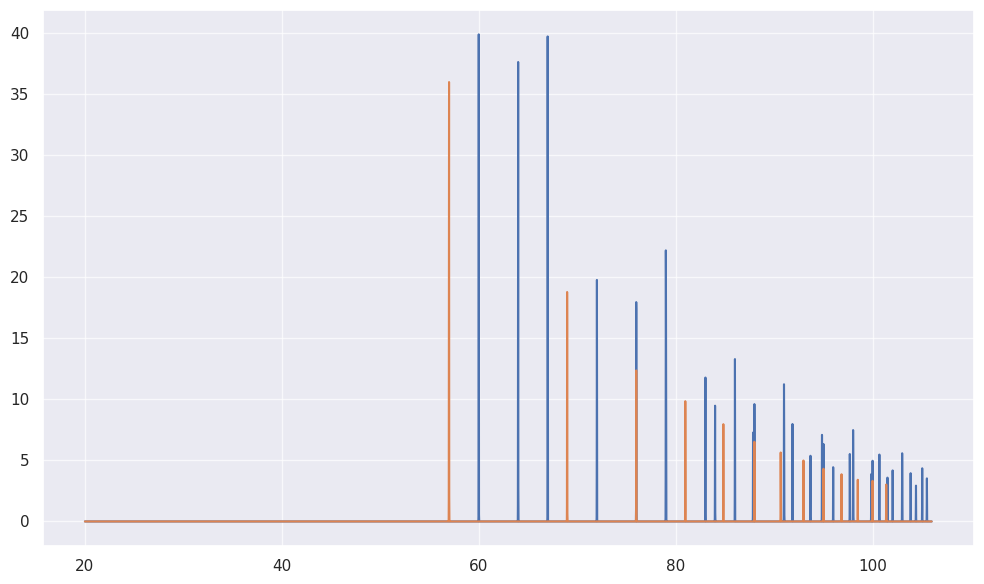

In [188]:
plt.plot(MIDI_X, chord(my_chord))
plt.plot(MIDI_X, overtones(x_axis[sorted_peaks[2]]))
plt.show()

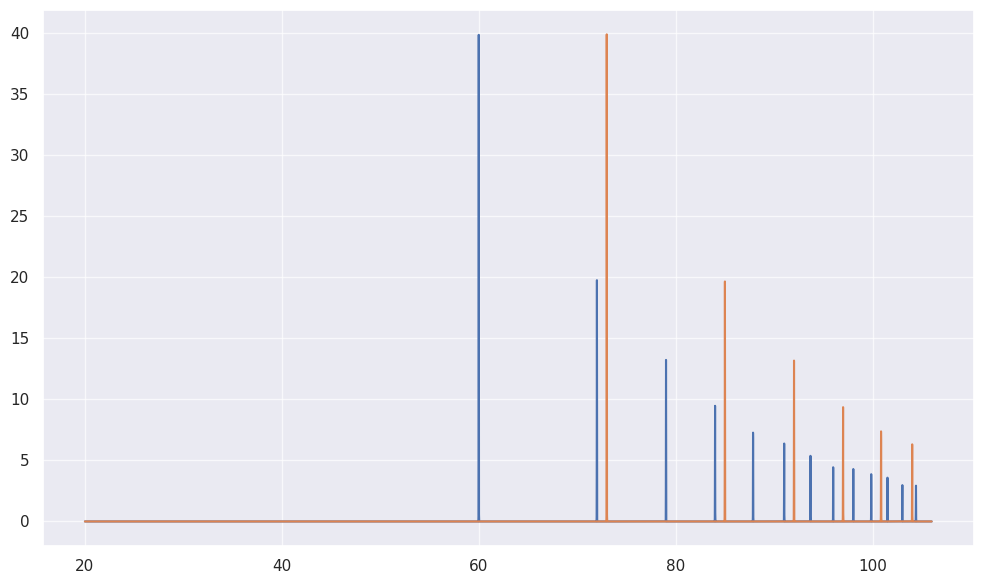

In [179]:
plt.plot(MIDI_X, chord([60]))
plt.plot(MIDI_X, chord([73]))
plt.show()

In [154]:
def differences_between_consecutive_pairs(lst):
    return [j - i for i, j in zip(lst, lst[1:])]

def has_two_consecutive_seconds(chord):
    diffs = differences_between_consecutive_pairs(chord)
    return any(elem in zip(diffs[:-1], diffs[1:]) for elem in [(2, 2), (2, 1), (1, 2), (1, 1)])

In [157]:
scale = (0, 2, 4, 5, 7, 9, 11)
ceiling = 108
base = 48
results = []
for var in permutations(scale):
    shifted = list(var)
    for idx in range(len(shifted) - 1):
        while shifted[idx] > shifted[idx + 1]:
            shifted[idx + 1] += 12
    shifted = [base + x for x in shifted]
    if shifted[-1] > ceiling:
        continue
    if has_two_consecutive_seconds(shifted):
        continue
    
    results.append(shifted)

print(f"Generated {len(results)} chords")

Generated 4325 chords


In [158]:
@dataclass
class Chord:
    notes: list
    peak_notes: list
    peak_strengths: list

In [159]:
def process_chord(my_chord):
    x_axis, swept = sweep(my_chord)
    peaks = top_n_peaks(swept, 10)
    return Chord(my_chord, x_axis[peaks], swept[peaks])

In [160]:
with Pool(8) as p:
    all_chords = p.map(process_chord, results)

In [168]:
sorted(all_chords, key=lambda x: x.peak_strengths[1], reverse=False)[:10]

[Chord(notes=[52, 62, 72, 79, 89, 95, 105], peak_notes=array([51.99804688, 49.98242188, 39.90429688, 42.92773438, 47.96679688,
        28.0625    , 38.140625  , 34.109375  , 32.84960938, 24.03125   ]), peak_strengths=array([126.04476267,  59.99727579,  56.42926252,  51.66323999,
         51.59389813,  44.79557033,  42.95967884,  38.02433336,
         37.14454989,  34.26458115])),
 Chord(notes=[59, 62, 72, 79, 89, 100, 105], peak_notes=array([58.99839744, 47.17307692, 49.94070513, 47.92788462, 52.9599359 ,
        42.89583333, 55.22435897, 31.07051282, 38.11538462, 34.08974359]), peak_strengths=array([119.97916547,  60.90907787,  57.40425983,  53.38153379,
         52.15747355,  50.68086005,  44.21738384,  43.62095805,
         43.3415015 ,  38.69607399])),
 Chord(notes=[52, 62, 72, 83, 91, 101, 105], peak_notes=array([51.99804688, 39.90429688, 49.98242188, 42.92773438, 28.0625    ,
        38.140625  , 47.96679688, 32.84960938, 34.109375  , 24.03125   ]), peak_strengths=array([134.8340

In [169]:
for n in [52, 62, 72, 79, 89, 95, 105]:
    print(midi_to_note(n))

E3
D4
C5
G5
F6
B6
A7
